In [1]:
import math
import random
import torch
import torchvision
import time 
from torchvision import datasets ,transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torch import nn 
from torch.nn.functional import relu ,softmax 
import copy 
from torch.utils.data import Subset
import pandas as pd 
import numpy as np
from PIL import Image

In [2]:
data_transform=transforms.Compose ([
                                          
                                          transforms.ToTensor(),
     
    
                                          
])


In [3]:


class light_source_dataset(Dataset):
    def __init__(self,path,transform):
        self.df_data=pd.read_csv(path)
        self.df_data['Classifier'] = pd.Categorical(pd.factorize(self.df_data['Classifier'])[0])
        self.labels=np.asarray(self.df_data.iloc[:,self.df_data.shape[1]-1])
        self.image_as_np=np.asarray(self.df_data.iloc[:,0:self.df_data.shape[1]-1]).astype('uint8')
        self.trans=transform
        
    def __len__(self):
        return len(self.df_data.index)
    def __getitem__(self,index):
        image_np=self.image_as_np[index,:,None]
       
        pillow_image=Image.fromarray(image_np.astype('uint8'))
        
        single_label=self.labels[index]
        if (self.trans is not None):
            img_as_tensor=self.trans(pillow_image)
        
        
            
        return (img_as_tensor,single_label)
        
dataset=light_source_dataset('WaveformEW/WaveformEW.csv',data_transform)
print(len(dataset))
train_size=int (len(dataset)*0.6)
test_size=len(dataset)-train_size
#trainloader=DataLoader(dataset,batch_size=1)
#seeding provided so that the data is always randomly splitted
torch.manual_seed(1)
train_data,test_data=torch.utils.data.random_split(dataset,[int (train_size), int (test_size)])
dataloader={'train':DataLoader(train_data,shuffle=False ,batch_size=16),
            'val':DataLoader(test_data,shuffle=False,batch_size=16
                            )}

dataset_sizes={'train':len(train_data),
               'val':len(test_data)}

device=torch.device("cuda:0"if torch.cuda.is_available () else "cpu")
print(dataset_sizes["train"])
print (dataset_sizes["val"])

#for images,labels in dataloader['train']:
 #   print(images.shape,labels)
 
    



5000
3000
2000


In [4]:

class Model(torch.nn.Module):
    def __init__(self):
        super (Model,self ).__init__()
        self .linear1=nn.Linear (40,20)
        self.linear2=nn.Linear(20,3)
        #self.drop_layer=nn.Dropout (p=0.4)
        
        
    def Forward (self,x):
        
        x=x.view(-1,40)
        #print(x.shape)
        act1=relu(self.linear1(x))
        #act1_mod=self.drop_layer(act1)
       
        act2=softmax(self.linear2(act1))
        
        
        return act2
    
    
   
        


  
  
  


      

In [5]:
torch.manual_seed(6)
model=Model()#creating the object of the class
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)



In [6]:
def train_model(model, criterion, optimizer, num_epochs=25):
  # the mask has to be specified 

      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      losses=[]
      accuracies=[]

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  
                  model.train()  # Set model to training mode
              else:

                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data.
              for inputs, labels in dataloader[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs= model.Forward(inputs)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)# backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #print (model.linear1.weight.grad)
                        #print (model.linear2.weight.grad)

                  # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                  

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]
              
            

              print('{} Loss: {:.4f} Acc: {:.4f} '.format(
                  phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase=='train':
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)


          

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model,losses,accuracies

In [7]:
model,losses,accuracies=train_model(model,criterion,optimizer,630)

Epoch 0/629
----------


D:\ana\envs\packt_torch\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


train Loss: 1.1003 Acc: 0.3380 
val Loss: 1.1001 Acc: 0.3410 
Epoch 1/629
----------
train Loss: 1.0998 Acc: 0.3380 
val Loss: 1.0997 Acc: 0.3440 
Epoch 2/629
----------
train Loss: 1.0994 Acc: 0.3370 
val Loss: 1.0993 Acc: 0.3470 
Epoch 3/629
----------
train Loss: 1.0990 Acc: 0.3367 
val Loss: 1.0989 Acc: 0.3535 
Epoch 4/629
----------
train Loss: 1.0986 Acc: 0.3393 
val Loss: 1.0985 Acc: 0.3555 
Epoch 5/629
----------
train Loss: 1.0982 Acc: 0.3463 
val Loss: 1.0982 Acc: 0.3625 
Epoch 6/629
----------
train Loss: 1.0978 Acc: 0.3467 
val Loss: 1.0978 Acc: 0.3685 
Epoch 7/629
----------
train Loss: 1.0974 Acc: 0.3567 
val Loss: 1.0974 Acc: 0.3730 
Epoch 8/629
----------
train Loss: 1.0970 Acc: 0.3637 
val Loss: 1.0971 Acc: 0.3800 
Epoch 9/629
----------
train Loss: 1.0965 Acc: 0.3700 
val Loss: 1.0967 Acc: 0.3810 
Epoch 10/629
----------
train Loss: 1.0961 Acc: 0.3763 
val Loss: 1.0963 Acc: 0.3865 
Epoch 11/629
----------
train Loss: 1.0957 Acc: 0.3843 
val Loss: 1.0959 Acc: 0.3980 
E

val Loss: 0.9808 Acc: 0.5770 
Epoch 96/629
----------
train Loss: 0.9713 Acc: 0.5773 
val Loss: 0.9804 Acc: 0.5770 
Epoch 97/629
----------
train Loss: 0.9708 Acc: 0.5777 
val Loss: 0.9800 Acc: 0.5770 
Epoch 98/629
----------
train Loss: 0.9704 Acc: 0.5777 
val Loss: 0.9796 Acc: 0.5775 
Epoch 99/629
----------
train Loss: 0.9700 Acc: 0.5777 
val Loss: 0.9793 Acc: 0.5775 
Epoch 100/629
----------
train Loss: 0.9696 Acc: 0.5777 
val Loss: 0.9789 Acc: 0.5775 
Epoch 101/629
----------
train Loss: 0.9691 Acc: 0.5777 
val Loss: 0.9786 Acc: 0.5770 
Epoch 102/629
----------
train Loss: 0.9688 Acc: 0.5777 
val Loss: 0.9783 Acc: 0.5755 
Epoch 103/629
----------
train Loss: 0.9684 Acc: 0.5770 
val Loss: 0.9780 Acc: 0.5755 
Epoch 104/629
----------
train Loss: 0.9680 Acc: 0.5770 
val Loss: 0.9777 Acc: 0.5755 
Epoch 105/629
----------
train Loss: 0.9677 Acc: 0.5777 
val Loss: 0.9774 Acc: 0.5750 
Epoch 106/629
----------
train Loss: 0.9673 Acc: 0.5780 
val Loss: 0.9771 Acc: 0.5750 
Epoch 107/629
---

train Loss: 0.9541 Acc: 0.5830 
val Loss: 0.9691 Acc: 0.5780 
Epoch 191/629
----------
train Loss: 0.9541 Acc: 0.5833 
val Loss: 0.9690 Acc: 0.5780 
Epoch 192/629
----------
train Loss: 0.9540 Acc: 0.5840 
val Loss: 0.9690 Acc: 0.5780 
Epoch 193/629
----------
train Loss: 0.9539 Acc: 0.5843 
val Loss: 0.9690 Acc: 0.5780 
Epoch 194/629
----------
train Loss: 0.9538 Acc: 0.5850 
val Loss: 0.9690 Acc: 0.5780 
Epoch 195/629
----------
train Loss: 0.9537 Acc: 0.5853 
val Loss: 0.9689 Acc: 0.5780 
Epoch 196/629
----------
train Loss: 0.9537 Acc: 0.5853 
val Loss: 0.9689 Acc: 0.5780 
Epoch 197/629
----------
train Loss: 0.9536 Acc: 0.5853 
val Loss: 0.9689 Acc: 0.5785 
Epoch 198/629
----------
train Loss: 0.9535 Acc: 0.5853 
val Loss: 0.9689 Acc: 0.5785 
Epoch 199/629
----------
train Loss: 0.9534 Acc: 0.5853 
val Loss: 0.9688 Acc: 0.5785 
Epoch 200/629
----------
train Loss: 0.9533 Acc: 0.5850 
val Loss: 0.9688 Acc: 0.5795 
Epoch 201/629
----------
train Loss: 0.9533 Acc: 0.5850 
val Loss: 0

val Loss: 0.9680 Acc: 0.5725 
Epoch 285/629
----------
train Loss: 0.9480 Acc: 0.5910 
val Loss: 0.9680 Acc: 0.5725 
Epoch 286/629
----------
train Loss: 0.9480 Acc: 0.5910 
val Loss: 0.9680 Acc: 0.5725 
Epoch 287/629
----------
train Loss: 0.9479 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5725 
Epoch 288/629
----------
train Loss: 0.9479 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5725 
Epoch 289/629
----------
train Loss: 0.9478 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5725 
Epoch 290/629
----------
train Loss: 0.9477 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5725 
Epoch 291/629
----------
train Loss: 0.9477 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5725 
Epoch 292/629
----------
train Loss: 0.9476 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5725 
Epoch 293/629
----------
train Loss: 0.9476 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5730 
Epoch 294/629
----------
train Loss: 0.9475 Acc: 0.5913 
val Loss: 0.9680 Acc: 0.5730 
Epoch 295/629
----------
train Loss: 0.9475 Acc: 0.5917 
val Loss: 0.9680 Acc: 0.5730 
Epoch 296/629

train Loss: 0.9436 Acc: 0.5983 
val Loss: 0.9684 Acc: 0.5735 
Epoch 380/629
----------
train Loss: 0.9436 Acc: 0.5983 
val Loss: 0.9684 Acc: 0.5730 
Epoch 381/629
----------
train Loss: 0.9435 Acc: 0.5983 
val Loss: 0.9684 Acc: 0.5730 
Epoch 382/629
----------
train Loss: 0.9435 Acc: 0.5987 
val Loss: 0.9684 Acc: 0.5730 
Epoch 383/629
----------
train Loss: 0.9434 Acc: 0.5987 
val Loss: 0.9684 Acc: 0.5730 
Epoch 384/629
----------
train Loss: 0.9434 Acc: 0.5990 
val Loss: 0.9684 Acc: 0.5725 
Epoch 385/629
----------
train Loss: 0.9433 Acc: 0.5990 
val Loss: 0.9684 Acc: 0.5725 
Epoch 386/629
----------
train Loss: 0.9433 Acc: 0.5993 
val Loss: 0.9684 Acc: 0.5730 
Epoch 387/629
----------
train Loss: 0.9433 Acc: 0.5993 
val Loss: 0.9684 Acc: 0.5730 
Epoch 388/629
----------
train Loss: 0.9432 Acc: 0.5993 
val Loss: 0.9684 Acc: 0.5730 
Epoch 389/629
----------
train Loss: 0.9432 Acc: 0.5993 
val Loss: 0.9684 Acc: 0.5730 
Epoch 390/629
----------
train Loss: 0.9431 Acc: 0.5993 
val Loss: 0

val Loss: 0.9690 Acc: 0.5720 
Epoch 474/629
----------
train Loss: 0.9394 Acc: 0.6050 
val Loss: 0.9691 Acc: 0.5720 
Epoch 475/629
----------
train Loss: 0.9394 Acc: 0.6047 
val Loss: 0.9691 Acc: 0.5720 
Epoch 476/629
----------
train Loss: 0.9393 Acc: 0.6047 
val Loss: 0.9691 Acc: 0.5720 
Epoch 477/629
----------
train Loss: 0.9393 Acc: 0.6053 
val Loss: 0.9691 Acc: 0.5720 
Epoch 478/629
----------
train Loss: 0.9392 Acc: 0.6053 
val Loss: 0.9691 Acc: 0.5715 
Epoch 479/629
----------
train Loss: 0.9392 Acc: 0.6053 
val Loss: 0.9691 Acc: 0.5715 
Epoch 480/629
----------
train Loss: 0.9391 Acc: 0.6050 
val Loss: 0.9691 Acc: 0.5715 
Epoch 481/629
----------
train Loss: 0.9391 Acc: 0.6050 
val Loss: 0.9692 Acc: 0.5715 
Epoch 482/629
----------
train Loss: 0.9391 Acc: 0.6053 
val Loss: 0.9692 Acc: 0.5715 
Epoch 483/629
----------
train Loss: 0.9390 Acc: 0.6053 
val Loss: 0.9692 Acc: 0.5715 
Epoch 484/629
----------
train Loss: 0.9390 Acc: 0.6053 
val Loss: 0.9692 Acc: 0.5715 
Epoch 485/629

train Loss: 0.9353 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 569/629
----------
train Loss: 0.9352 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 570/629
----------
train Loss: 0.9352 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 571/629
----------
train Loss: 0.9351 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 572/629
----------
train Loss: 0.9351 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 573/629
----------
train Loss: 0.9351 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 574/629
----------
train Loss: 0.9350 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 575/629
----------
train Loss: 0.9350 Acc: 0.6103 
val Loss: 0.9703 Acc: 0.5695 
Epoch 576/629
----------
train Loss: 0.9349 Acc: 0.6107 
val Loss: 0.9703 Acc: 0.5695 
Epoch 577/629
----------
train Loss: 0.9349 Acc: 0.6107 
val Loss: 0.9704 Acc: 0.5695 
Epoch 578/629
----------
train Loss: 0.9348 Acc: 0.6107 
val Loss: 0.9704 Acc: 0.5690 
Epoch 579/629
----------
train Loss: 0.9348 Acc: 0.6110 
val Loss: 0

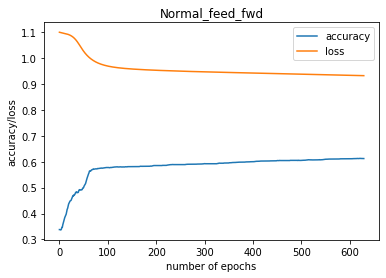

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(630),accuracies,label='accuracy')
plt.plot(range(630),losses,label='loss')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('accuracy/loss')
plt.title('Normal_feed_fwd')
plt.savefig('wave 20/Normal_feed_fwd.jpg')